This notebook generates a series of LTL formula and associated traces from the resultant automaton DAG.

*NOTE*  

This notebook requires Python 3.10 or later to run.


In [5]:
import random
import sys 
import re
import dataclasses
import copy 

import spot
import spot.gen as sg

import ply.lex as lex
import ply.yacc as yacc

from pathlib import Path

from graphviz import Digraph
from graphviz import Graph
from graphviz import Source   # Used to read existing dot files

spot.setup(size='12,8')

In [6]:
class bcolors:
    MAGENTA = '\033[95m'
    BLUE    = '\033[94m'
    CYAN    = '\033[96m'
    GREEN   = '\033[92m'
    ORANGE  = '\033[93m'
    RED     = '\033[91m'
    GREY    = '\033[90m'
    ENDC    = '\033[0m'
    BOLD    = '\033[1m'
    UNDERLINE = '\033[4m'

In [7]:

dLineSeparator = f'='*40
lineSeparator = f'-'*40


----

### The Lexer

See the docs at:  
https://ply.readthedocs.io/_/downloads/en/latest/pdf/

In [8]:
class DotLexer(object):
    reserved = {
                'digraph'     : 'DIGRAPH',
                'node'        : 'NODESTYLE',
                'edge'        : 'EDGESTYLE',
                'labelloc'    : 'LABELLOC',
                'rankdir'     : 'RANKDIR',
                'fontname'    : 'FONTNAME',
                'size'        : 'SIZE',
                'width'       : 'WIDTH',
                'height'      : 'HEIGHT',
                'label'       : 'LABEL',
                'shape'       : 'SHAPE',
                'style'       : 'STYLE',
                'fillcolor'   : 'FILLCOLOR',
                'arrowhead'   : 'ARROWHEAD',
                'arrowsize'   : 'ARROWSIZE',
                'peripheries' : 'PERIPHERIES',
                'I'           : 'INITIALSTATE',
               }
    
    literals = ['(',')','<','>','[',']','=',',','{','}']
        
    tokens = [ 
                'STRING',
                'HTMLSTRING',
                'ID',
                'CONNECTOR',
                'NUMBER',
                'NOT',
                'AND',
                'OR',
              ]  + list(reserved.values())
    
    t_NOT       = r'!'
    t_AND       = r'&amp;'
    t_OR        = r'\|'
    t_CONNECTOR = r'->'
    t_NUMBER    = r'(\.|[0-9])[0-9]*'
    
    #A string containing ignored characters (spaces and tabs)
    t_ignore  = ' \t\n\r'
    
    def __init__(self):
        # Build the lexer
        self.lexer = lex.lex(module=self,debug=0,reflags=re.UNICODE | re.VERBOSE)
    
    # def t_INF(t):
    #     r'(<(inf|Inf).*>)|(<\[Büchi\]>)|(<font.*font>)'
    #     t.value = t.value
    #     return t
        
    def t_HTMLSTRING(self,t):
        r'(<br\/>|(<(inf|Inf).*>)|(<\[Büchi\]>)|(<\/?font[^>]*>)|<([a-zA-Z][a-zA-Z0-9]*)\b[^>]*>.*?</\3>)'
    #    r'<([a-zA-Z][a-zA-Z0-9]*)\b[^>]*>.*?</\2>'
        t.value = t.value
        return t
        
    def t_ID(self,t):
        r'[a-zA-Z\u0080-\u3000/][a-zA-Z0-9\.\u0080-\u3000/]*'
        t.type = self.reserved.get(t.value,'ID')    # Check for reserved words
        return t
        
    def t_STRING(self,t):
        r'".*"'
        t.value = t.value
        return t
        
    # # Error handling rule
    def t_error(self,t):
        print("Illegal character '%s'" % t.value[0])
        print(t.value[0].encode('raw_unicode_escape'))
        t.lexer.skip(1)


----

### The Parser

In [9]:
class DotParser(object):

    tokens = DotLexer.tokens
    literals = DotLexer.literals
    reserved= DotLexer.reserved
    
    precedence = (
        ('left', 'AND', 'OR'),
        ('left', 'NOT'),
    )

    def __init__(self):
        self.lexer = DotLexer()
        self.parser = yacc.yacc(module=self,write_tables=False)

    def parse(self,formula,auto):
        self.auto = auto
        self.parser.parse(formula.formulaDot, debug=False)
        return self.auto
        
    def p_graph(self,p):
        'graph : DIGRAPH STRING body'
        p[0] = f'{p[1]} {p[2]} {p[3]}'
    #    print(f'graph:       {p[0]}')
    
    def p_body(self,p):
        '''body : '{' statements '}' '''
        p[0] = f'{p[1]} \n{p[2]} \n{p[3]}'
    #    print(f'Body:        {p[0]}')
    
    def p_statements2(self,p):
        '''statements : statements  statement
                      | statements  style
                      '''
        p[0] = f'{p[1]} {p[2]}\n'
        # print(f'statements2: {p[0]}')
    
    def p_statements1(self,p):
        '''statements : statement'''
        p[0] = f'{p[1]}'
        # print(f'statements1: {p[0]}')
    
    def p_rankdir(self,p):
        '''statement : RANKDIR '=' ID'''
        p[0] = f'{p[1]} = {p[3]}'
    #    print(f'rankdir:     {p[0]}')
    
    def p_label(self,p):
        '''label : LABEL '=' html
                 | LABEL '=' STRING 
                 | LABEL '=' extra
                 '''
        p[0] = Label(p[1],p[3])
        # print(f'label.value: {p[0].label}: {p[0].value}, {p[3]}, {type(p[3])}')
    
    def p_extraText(self,p):
        '''extra : HTMLSTRING
                 | extra HTMLSTRING
                 '''
        if len(p) == 2:
            p[0] = f'{p[1]}'
        else:
            p[0] = f'{p[1]} {p[2]}'
        # print(f'Extra: {p[0]}')
            
    def p_nodeStyle(self,p):
        '''statement : NODESTYLE '[' style ']' '''
        p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]}'
        # print(f'node style:  {p[0]} {type(p[3])}')
    
    def p_edgeStyle(self,p):
        '''statement : EDGESTYLE '[' style ']' '''
        p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]}'
    #    print(f'edge style:  {p[0]}')
    
    def p_node(self,p):
        '''statement : NUMBER '[' style ']' 
                     | INITIALSTATE '[' style ']' '''
    #    p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]}'
        self.auto.addState(p[1],p[3])
        # print(f'node:  {p[1]} | {p[3]}')
    
    def p_nodeConnect(self,p):
        '''statement : INITIALSTATE CONNECTOR NUMBER 
                     | INITIALSTATE CONNECTOR NUMBER '[' style ']'
                     | NUMBER CONNECTOR NUMBER 
                     | NUMBER CONNECTOR NUMBER '[' style ']' 
                     '''
        if len(p) == 4:
            p[0] = f'{p[1]} {p[2]} {p[3]}'
            self.auto.addEdge(p[1],p[3],Label('label',Predicate('1')))
        else:
            p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]} {p[5]} {p[6]}'
                
            self.auto.addEdge(p[1],p[3],p[5])
            self.auto.addPredicate(p[5].value.predicates())
        # print(f'nodeConnect:  {p[0]}')
    
    def p_style(self,p):
        '''style : style ','
                 | style LABELLOC    '=' STRING 
                 | style SHAPE       '=' STRING
                 | style STYLE       '=' STRING
                 | style STYLE       '=' ID
                 | style FILLCOLOR   '=' STRING
                 | style FONTNAME    '=' STRING
                 | style ARROWHEAD   '=' ID
                 | style ARROWSIZE   '=' NUMBER
                 | style WIDTH       '=' NUMBER
                 | style WIDTH       '=' STRING
                 | style HEIGHT      '=' NUMBER
                 | style HEIGHT      '=' STRING
                 | style PERIPHERIES '=' NUMBER
                 | LABELLOC    '=' STRING 
                 | SHAPE       '=' STRING
                 | STYLE       '=' STRING
                 | STYLE       '=' ID
                 | FILLCOLOR   '=' STRING
                 | FONTNAME    '=' STRING
                 | ARROWHEAD   '=' ID
                 | ARROWSIZE   '=' NUMBER
                 | WIDTH       '=' NUMBER
                 | WIDTH       '=' STRING
                 | HEIGHT      '=' NUMBER
                 | HEIGHT      '=' STRING
                 | PERIPHERIES '=' NUMBER
                 '''
        if len(p) == 2:
            p[0] = f'{p[1]}'        
        elif len(p) == 3:
            # print(f'{bcolors.GREEN}** p[1] type: {type(p[1])} = {p[1]}, P[2] type: {type(p[2])} = {p[2]}{bcolors.ENDC}',end='')
            if type(p[1]) == Label:
                # print(f'*{p[1].value}*{type(p[1].value)}*',end='')
                if type(p[1].value) == Predicate:
                    p[1].value.value = p[1].value.value + p[2]
                    p[0] = p[1]
                    # print(f'*{p[1].value}*{type(p[1].value)}* *{p[0].value}*{type(p[0].value)}*')
                else:
                    # print()
                    p[0] = f'{p[1]} {p[2]}'
            else:
                # print()
                p[0] = f'{p[1]} {p[2]}'
        elif len(p) == 4:
            p[0] = f'{p[1]} = {p[3]}'
        else:
            # print(f'{bcolors.GREEN}** p[1] type: {type(p[1])} = {p[1]}, P[2] type: {type(p[2])} = {p[2]}{bcolors.ENDC}',end='')
            if type(p[1]) == Label:
                # print(f'*{p[1].value}*{type(p[1].value)}*',end='')
                if type(p[1].value) == Predicate:
                    p[1].value.value = p[1].value.value + f'{p[2]} = {p[4]}'
                    p[0] = p[1]
                    # print(f'*{p[1].value}*{type(p[1].value)}* *{p[0].value}*{type(p[0].value)}*')
                else:
                    # print()
                    p[0] = f'{p[1]} {p[2]} = {p[4]}'
            else:
                # print()
                p[0] = f'{p[1]} {p[2]} = {p[4]}'
        # print(f'style:       {p[0]}, {bcolors.BLUE}{type(p[0])}{bcolors.ENDC} {len(p)}')
    
    def p_styleLabel(self,p):
        '''style : label
                 | style label
                 '''
        if len(p) == 2:
            p[0] = p[1]
        elif len(p) == 3:
            p[1].addLabel(p[2])
            p[0] = p[1]
        # print(f'styleLabel:  {p[0]}, {bcolors.RED}{type(p[0])}{bcolors.ENDC} len(p): {len(p)}')
       
    def p_html(self,p):
        '''html : '<' htmlbody '>'
                '''
        p[0] = p[2]
        # p[0] = f'{p[1]} {p[2]} {p[3]}'
        # print(f'html:         {p[0]}, {bcolors.RED}{type(p[0])}{bcolors.ENDC}')
    
    def p_htmlbody(self,p):
        '''htmlbody : STRING
                    | equation
                    | htmlbody equation  
                    | htmlbody '(' HTMLSTRING ')'
                    '''

        if len(p) == 2:
            p[0] = p[1]
        elif len(p) == 3:
            print(f'hb2 {p[1]} {p[2]}')
            p[1].addLabel(p[2])
            p[0] = p[1]
        else:
            print(f'hb3 {p[1]} {type(p[1])} {p[3]} {type(p[3])} ')
            p[1].addLabel(p[3])
            p[0] = p[1]
            
        # print(f'htmlbody:     {p[0]}, {bcolors.RED}{type(p[0])}{bcolors.ENDC} len(p): {len(p)}')
    
    def p_equation_id(self,p):
        ''' equation : equation term
                     '''
        p[1].addLabel(p[2])
        p[0] = p[1]
        # print(f'html id:    {p[0]} {type(p[0])} {p[1]} {type(p[1])} {p[2]} {p[1].label}')
    
    def p_equation_eq(self,p):
        ''' equation : equation '(' equation ')'
                     | equation '[' equation ']'
                     '''
        p[1].addLabel(p[3])
        p[0] = p[1]
        # print(f'equation eq:    {p[0]} {type(p[0])}')
    
    def p_equation_html(self,p):
        ''' equation : equation HTMLSTRING
                     '''
        p[0] = p[1]
        # print(f'html equation:    {p[0]} {type(p[0])} {p[1]} {type(p[1])}')
    
    def p_equation_binary_and(self,p):
        ''' equation : equation AND equation
                     '''
        p[0] = AndNode(p[1],p[3])
        # print(f'EQ And:   {p[0]} {type(p[0])}')
    
    def p_equation_binary_or(self,p):
        ''' equation : equation OR equation
                     '''
        p[0] = OrNode(p[1],p[3])
        # print(f'EQ Or:    {p[0]} {type(p[0])}')
    
    def p_equation_term(self,p):
        ''' equation : term
                     '''
        p[0] = p[1]
        # print(f'EQ term:  {p[0]} {type(p[0])}')
        
    def p_equation_unary(self,p):
        ''' equation : NOT equation
                     '''
        p[0] = UniNode(p[1],p[2])
        # print(f'EQ Uni:   {p[0]} {type(p[0])}')
    
    def p_equation_sub(self,p): 
        ''' term : '(' equation ')'
        '''
        p[0] = p[2]
        # print(f'EQ Sub:  {p[0]} {type(p[0])}')
        
    def p_equation_predicate(self,p):
        ''' term : NUMBER
                 | ID
                 '''
        p[0] = Predicate(p[1])
        # print(f'EQ Pred: {p[0]} {type(p[0])}')
        
    def p_graphsize(self,p):
        '''statement : SIZE '=' STRING '''
        p[0] = f'{p[1]} = {p[3]}'
    #    print(f'graphsize:   {p[0]}')
    
    # Error rule for syntax errors
    def p_error(self,p):
        print("Syntax error in input!")
        print(f'{p}')


In [10]:
__file__ = "DC_Parser.ipynb"

# Build the lexer
#lexer = lex.lex(debug=0,reflags=re.UNICODE | re.VERBOSE)

----
#### Code for testing just the parser

In [11]:
# Give the lexer some input
#lexer.input(graph)

# Tokenize
#for tok in lexer:
#    print(f'{tok.type:15} {tok.value:<6} {tok.lineno:3} {tok.lexpos:3} {tok}')

----
### LTL Tracegen

What follows is all the support code for building an automaton from an equation. The basic flow of the code is as follows:

* Provide an equation. It may be given directly or randomly generated by Spot.
* Spot is used to convert the equation into a Buchi automaton in dot format.
* The dot graph is parsed into an new automaton.
* Randomly walk the automaton and capture the predicate states on the edges taken.

In [12]:
def getSeed(rndSeed=False,printSeed=False):
#    seed = 96996 # generates a long diagram with multiple buchi labels
    seed = 79398 # generates a medium diagram with a graph label containing an & - not accounted for in yacc syntax
#    seed = 64165 # generates a graph title with brackets and html
    
    if rndSeed == True:
        seed = random.randrange(100000)

    if printSeed == True:
        print(f'Seed Used: {seed}')

    return(seed)

In [13]:
class DotGraph:
    def __init__(self):
        self.dot = Digraph(comment='Digraph generated by LTL_TraceGen_Spot',graph_attr=dict(rankdir='LR'))
        self.dot.attr('node',shape='circle',fontname="Helvetica")
        self.dot.attr('edge',fontname='Helvetica')


    def addState(self,state,accepting=False,color='black',fontcolor='black'):
        if state in ['Init','init','I']:
            self.dot.node(state,style='invis',shape='plaintext',width='0')
        else:
            if accepting == True:
                shape = 'doublecircle'
            else:
                shape = 'circle'
            self.dot.node(state,shape=shape,color=color,fontcolor=fontcolor)

    def addEdge(self,fromState,toState,label="",color='black',fontcolor='black'):
        if fromState in ['Init','init','I']:
            self.dot.edge(fromState,toState,'',color=color,fontcolor=fontcolor)
        else:
            self.dot.edge(fromState,toState,label,color=color,fontcolor=fontcolor)

    def addTitle(self,title):
        pass
        
    def showGraph(self,graphPrint,graphSource,graphFile):
    
        if graphSource == True:
            print(self.dot)
    
        if graphPrint == True:
            display(self.dot)
    
        if graphFile['save'] == True:
            self.dot.render(graphFile['name'], format=graphFile['format'])
        

----
#### Node Classes

The following classes are to create an binary tree of an equation


In [14]:
class Node:

    label = ''

    def addLabel(self,label):
        self.label = f'{self.label} {label}'
        return

    def trace(self):
        pass

    def evaluate(self):
        pass

    def clearState(self):
        pass

class BinNode(Node):
    def __init__(self,op,childL=None, childR=None):
        self.op = op
        self.childL = childL
        self.childR = childR
        self.stateL : (Bool, None) = None
        self.stateR : (Bool, None) = None

    def predicates(self):
        return list(set(self.childL.predicates() + self.childR.predicates()))

    def clearState(self):
        self.stateL = None
        self.stateR = None

        self.childL.clearState()
        self.childR.clearState()

    def __repr__(self):
        return f'({self.childL} {self.op} {self.childR})'

class AndNode(BinNode):
    def __init__(self,childL=None, childR=None):
        super().__init__('&',childL,childR)

    def trace(self):
        return self.childL.trace() + self.childR.trace()

    def evaluate(self,step):
        if self.stateL == None:
            self.stateL = self.childL.evaluate(step)

        if self.stateR == None:
            self.stateR = self.childR.evaluate(step)

        if (self.stateL != None) and (self.stateR != None):
            state = self.stateL & self.stateR
        else:
            state = None
            
#        print(f'AND {step} {self.stateL} & {self.stateR} {state}')
        return state
        
class OrNode(BinNode):
    def __init__(self,childL=None, childR=None):
        super().__init__('|',childL,childR)

    def trace(self):
        if random.randint(0,1) == 0:
            return (self.childL.trace())
        else:
            return (self.childR.trace())

    def evaluate(self,step):
        if self.stateL == None:
            self.stateL = self.childL.evaluate(step)

        if self.stateR == None:
            self.stateR = self.childR.evaluate(step)

        if (self.stateL != None) and (self.stateR != None):
            state = self.stateL | self.stateR
            
        elif (self.stateR != None):
            state = self.stateR
            
        elif (self.stateL != None):
            state = self.stateL
            
        else:
            state = None
            
#        print(f'OR  {step} {self.stateL} | {self.stateR} {state}')
        return state

class UniNode(Node):
    def __init__(self,op,child=None):
        self.op = op
        self.child = child
        self.state : (Bool, None) = None

    def predicates(self):
        return self.child.predicates()

    def trace(self):
        children = []
        for child in self.child.trace():
            if child[0] == '!':
                children.append(child[1:])
            else:
                children.append(f'!{child}')
        return children

    def evaluate(self,step):
        if self.state == None:
            self.state = self.child.evaluate(step)
            if self.state != None:
                self.state = not(self.state)
#            print(f'NOT {step} {self.state}')
        return self.state

    def clearState(self):
        self.state = None
        self.child.clearState()
        
    def __repr__(self):
        return f'{self.op}{self.child}'

class Predicate(Node):
    
    def __init__(self,value):
        self.value = value
        self.state = None

    def getValue(self):
        return self.value
        
    def predicates(self):
        return [self.value]

    def trace(self):
        return [self.value]

    def evaluate(self,step):
        if self.state == None:
            if (self.value in step) or (self.value == '1'):
                if step[0] == '!':
                    self.state = False
                else:
                    self.state = True
        #     print(f'PRD {step} {self.value} {self.state}')
        # else:
        #     print(f'PRD {step} {self.value} X')
        return self.state

    def clearState(self):
        self.state = None

    def __repr__(self):
        return f'{self.value}'
        

----
The following classes are used to create an automaton data structure of labeled Nodes and Edges  

The data structures go together as follows:

<img src="LTL TraceGenDataStruct.svg" width=”5000” align="center" /> 




In [15]:
@dataclasses.dataclass
class Step:

    fromState  : str = ''
    toState    : str = ''
    predicates : str = ''
        
    def __repr__(self):
        str = f'{self.fromState:3} -> {self.toState:3}: {self.predicates}'

        return str

In [16]:
@dataclasses.dataclass
class Trace:
    steps : list[Step] =  dataclasses.field(default_factory=list)
    position : int = 0

    def addStep(self,step):
        self.steps.append(step)

    def step(self):
        for step in self.steps:
            yield step.predicates

    def start(self):
        self.position = 0
        return self.steps[self.position]

    def next(self):
        if self.position < len(self.steps):
            self.position += 1
            return self.steps[self.position-1]
        else:
            return None

    def back(self):
        if self.position > 0:
            self.position -= 1
            return self.steps[self.position]
        else:
            return None

    def traceAsStr(self):
        str = ''
        for step in self.steps:
            str = str + ','.join(step.predicates) + ';'
        return str

    def __repr__(self):
        str = f'S   -> S\'   Predicates\n{lineSeparator}\n'
        for step in self.steps:
           str = str + f'{step}\n'
        return str
    
    

In [17]:
class Label:

    label = ''
    
    def __init__(self,label: str,value: Node):

        # Propogate up any labels on the value Nodes.
        if isinstance(value,Node) == True:
            self.label = value.label
        else:
            self.label = label
            
        self.value = value

    def getValue(self):
        return self.value.getValue()

    def getLabel(self):
        return self.label
        
    def updateLabel(self,newInfo):
        self.value += newInfo

    def trace(self):
        return(self.value.trace())

    def evaluate(self,step):
        self.value.clearState()
        finalEval = None
        for symbol in step.predicates:
            eval = self.value.evaluate(symbol)
            if eval != None:
                if finalEval == None:
                    finalEval = eval
                else:
                    finalEval = finalEval & eval

        stepPreds = [step.predicates[i].replace('!','') for i in range(len(step.predicates))]
        totalPredsCovered = len(set(self.value.predicates()).intersection(stepPreds))
#        print(f'{self.value.predicates()} vs {stepPreds} -> {set(self.value.predicates()).intersection(stepPreds) != set(self.value.predicates())} Covered: {totalPredsCovered}')
        if type(self.value) != OrNode:
            if set(self.value.predicates()).intersection(stepPreds) != set(self.value.predicates()):
                finalEval = None
        return [finalEval, totalPredsCovered]
        
    def __repr__(self):
        return f' {self.value} '

In [18]:
class Edge:
    
    def __init__(self,fromState,toState,label):
        if label.label != '':
            self.label = label.label
        else:
            self.label = label
        self.fromState   = fromState
        self.toState     = toState
        self.label       = label
        self.totalVisits = 0

    def reset(self):
        self.totalVisits = 0

    def getNextState(self):
        return self.toState.stateNum
        
    def trace(self):
        return(self.label.trace())

    def evaluate(self,step):
        [eval,coverage] = self.label.evaluate(step)
        if eval == True:
            print(f'State: {self.fromState.stateNum} -> {self.toState.stateNum}, Symbols: {step.predicates} : {eval} Coverage {coverage} {self.label}')
        return [self.toState,[eval,coverage]]

    def isBuchiEdge(self):
        return (self.label.getLabel() != '')

    def __repr__(self):
        buchi = '*' if self.isBuchiEdge() == True else ''
        return  f'\t{self.toState.stateNum}: {self.label} {buchi}'
    

In [19]:
class State:

    label    = ''
    edgesOut = {}
    accepting    = False
    
    def __init__(self,stateNum,label):
        self.stateNum     = stateNum
        self.label        = label
        self.edgesOut     = []

        # Vars for tracking steps through state
        self.statesSeen   = {}
        self.visitCount   = 0
        self.stateVisited = False
        self.trap         = False

        if "peripheries" in self.label.getValue():
            self.accepting = True
        
    def addEdge(self,edge):
        self.edgesOut.append(edge)

    def isTerminal(self):
        
        terminal = True
        if len(self.edgesOut) == 0:
            return terminal
        else:
            for edge in self.edgesOut:
                if edge.getNextState() != self.stateNum:
                    return False
        return terminal

    def getBuchiEdgeCnt(self):
        cnt = 0
        for edge in self.edgesOut:
            if edge.isBuchiEdge():
                cnt += 1

        return cnt

    # This check is recursive, walking through states. visitList keeps track of states visited. 
    # When we see a next state already on the list we know we've been here before so stop going
    # forward and prevent an infinite loop.
    def checkLowCoverage(self,fromState,visitList,min,traceQual):
        # print(f'!')
        lowCoverageEdges = []
        newMin = 100
        trapCnt = 0
        for edge in self.edgesOut:
            if (edge.toState.trap == False) | (traceQual == 'Any'):
                if edge.totalVisits < newMin:
                    newMin = edge.totalVisits
                if edge.toState not in visitList:
                    # print(f' fromState: {fromState.stateNum} toSTate: {edge.toState.stateNum} cnt: {edge.totalVisits} Trap? {edge.toState.trap} edge: {edge}')
                    if edge.totalVisits <= min:
                        lowCoverageEdges.append(edge)
                    else:
                        [edgeList, lowMinSeen] = edge.toState.checkLowCoverage(edge.toState,visitList+[fromState],min,traceQual)
                        if len(edgeList) > 0:
                            lowCoverageEdges.append(edge)
                        if lowMinSeen < newMin:
                            newMin = lowMinSeen
            else:
                trapCnt += 1

        if trapCnt == len(self.edgesOut):
            self.trap = True
            
        # print(lowCoverageEdges)
        # print('!!')
        return [lowCoverageEdges,newMin]
        
    def step(self,traceQual='Any'):
        # print('>')
        [lowCoverEdges, newMin] = self.checkLowCoverage(self,[],self.minVisits,traceQual)
        if len(lowCoverEdges) == 0:
            for edge in self.edgesOut:
                if (edge.toState.trap == False) | (traceQual == 'Any')| (traceQual == 'Bad'):
                    lowCoverEdges.append(edge)
        if newMin > self.minVisits:
            self.minVisits = newMin
        edge  = lowCoverEdges[random.randint(0, len(lowCoverEdges)-1)]   
        edge.totalVisits += 1
        self.statesSeen[edge.toState.stateNum] += 1
        self.stateVisited = True
        # print(f'CurState: {self.stateNum}, Next State: {edge.toState.stateNum}, States Seen: {self.statesSeen}, Coverage: {lowCoverEdges}, Min coverage seen: {newMin}')
        # print('<\n')
        return Step(self.stateNum,edge.toState.stateNum,edge.trace())

    def evaluate(self,trace: Trace, traceLog: list):
        edgeEval = []
        traceLog.append(self.stateNum)
#        print(f'State> {self.stateNum} {traceLog}')
        eval = []
            
        step = trace.next()
        if step != None:
            for edge in self.edgesOut:
                eval = edge.evaluate(step)
                if eval[1][0] == True:
                    edgeEval.append(eval)
    
#            print(edgeEval)
            if len(edgeEval) == 1:
                nextState = edgeEval[0][0]
                maxCover = edgeEval[0][1][1]
            else:
                maxCover = 0
                nextState = None
                for candidate in edgeEval:
    #                print(f'{candidate} | {candidate[0].stateNum} | {candidate[1][1]}')
                    if candidate[1][1] > maxCover:
                        maxCover = candidate[1][1]
                        nextState = candidate[0]

            if nextState == None:
                print(f'No next state @ state: {self.stateNum} Step: {step.predicates}')
            else:
                traceLog, eval = nextState.evaluate(trace,traceLog)
#        print(f'State< {self.stateNum}')
        return traceLog, eval 

    def edgeList(self):
        return self.edgesOut

    def edgesVisited(self):
        edgeVisitCnt = 0
        for edge in self.edgesOut:
            if edge.totalVisits > 0:
                edgeVisitCnt += 1
        return edgeVisitCnt

    def edgesTotal(self):
        return len(self.edgesOut)
        
    def reset(self):
        
        for edge in self.edgesOut:
            edge.reset()
            self.statesSeen[edge.toState.stateNum] = 0
        
        self.visitCount   = 0
        self.stateVisited = False
        self.minVisits    = 0
        self.trap         = (self.isTerminal() & (self.getBuchiEdgeCnt() == 0) & (self.accepting == False))
        
    def __repr__(self):
        str =  f'{self.stateNum} Total Edges Out: {len(self.edgesOut)}\n'
        for edge in self.edgesOut:
            str = str + f'{edge}\n'
        return str
    

In [141]:
MAX_ADD = 10

class Automaton:

    states      = {}
    predicates  = []
    terminals   = []
    startStates = []
    curState    = 0
    trace       = []
    traceLog    = []
    allTraces   = []
    
    def __init__(self):
        self.states      = {}
        self.edges       = []
        self.predicates  = []
        self.terminals   = []
        self.startStates = []
        self.trace       = []
        self.allTraces   = []

    def addState(self,stateNum,stateLbl):
        if stateNum not in self.states:
            if stateNum == 'I':
                self.startStates.append(stateNum)
                pred = Predicate(stateLbl)
                stateLbl = Label('label',pred)
            self.states[stateNum] = State(stateNum,stateLbl)
#            print(f'addNode: {stateNum} {stateLbl}')
        else:
            print(f'addNode: {stateNum} Duplicate Node')

    def addEdge(self,stateFrom,stateTo,label):
        edge = Edge(stateFrom,stateTo,label)
        self.edges.append(edge)
        self.states[stateFrom].addEdge(edge)
#        print(f'addEdge {stateFrom} {stateTo} {label}')
        pass

    def addPredicate(self,predicates):
        if '1' in predicates:
            predicates.remove('1')
        self.predicates = list(set(self.predicates + predicates))

    def finishBuild(self):
        for state in self.states.values():
            for edge in state.edgesOut:
                edge.fromState = self.states[edge.fromState]
                edge.toState   = self.states[edge.toState]

        tmpList = []
        for stateNum in self.startStates:
            if (stateNum == 'I'):
                if (len(self.states['I'].edgesOut) == 1):
                    newStart = self.states['I'].edgesOut[0].toState.stateNum
                else:
                    newStart = 'I'
                tmpList.append(newStart)
            else:
                tmpList.append(stateNum)
        self.startStates = tmpList
            
                
    def getTerminals(self):
        self.terminals  = []
        for stateNum, stateStruct in self.states.items():
            if stateStruct.isTerminal() == True:
                self.terminals.append(stateNum)
                
    def reset(self,resetLog=True):

        if resetLog == True:
            for stateNum, stateStruct in self.states.items():
                stateStruct.reset()
            self.allTraces   = []

        self.trace = Trace()
        self.curState = self.startStates[0]

    def step(self,traceQual='Any'):
        step  = self.states[self.curState].step(traceQual)
        self.states[step.toState].visitCount += 1
        self.trace.addStep(step)
        self.curState = step.toState
        return self.states[step.toState].accepting

    def evaluate(self,trace):
        trace.start()
        self.traceLog = []
        self.traceLog, eval = self.states[self.startStates[0]].evaluate(trace,self.traceLog)

    def genTrace(self,tracePrint=False,traceQual='Any'):
        
        self.reset(resetLog=False)

        accepting = False
        for i in range(0,runLen):
            accepting = self.step(traceQual)
            while (traceQual == 'Bad') and (self.states[self.curState].trap == False):
                self.step(traceQual)

        if traceQual == 'Good':
            added = 0
            while (accepting == False) and (added < MAX_ADD):
                accepting  = self.step(traceQual)
                added += 1

            if added >= MAX_ADD:
                print(f'Trace could not find accepting state after 10 additional moves.\nTo adjust the allowed number of moves, change MAX_ADD')
               
        if tracePrint == True:
            self.printTraceLog()
        self.allTraces.append(self.trace)

    def getTrace(self):
        return self.trace.traceAsStr()
            
    def printTraceLog(self,trace,verbose=0,color=False):
        match verbose:
            case 0:
                step = trace.start()
                done = False
                while done != True:
                    cStart = ''
                    cEnd   = ''
                    if color == True:
                        if self.states[step.toState].accepting == True:
                            cStart = bcolors.GREEN
                        elif self.states[step.toState].trap == True:
                            cStart = bcolors.RED
                        cEnd   = bcolors.ENDC
                    print(f'{cStart}{step.toState}{cEnd}',end='')
                    step = trace.next()
                    if step == None:
                        done = True     
                    else:
                        print(f', ',end='')
                print('')
            case 1:
                print(f'S   -> S\'   Predicates\n{lineSeparator}')
                step = trace.start()
                done = False
                while done != True:
                    cStart = ''
                    cEnd   = ''
                    if color == True:
                        if self.states[step.toState].accepting == True:
                            cStart = bcolors.GREEN
                        elif self.states[step.toState].trap == True:
                            cStart = bcolors.RED
                        cEnd   = bcolors.ENDC
                    print(f'{cStart}{step}{cEnd}')
                    step = trace.next()
                    if step == None:
                        done = True     
            case 2:
                auto.evaluate(trace)
                print(f'Evaluation Trace Log: {auto.traceLog}')
            case _:
                print(f'{trace}')
        
    def printVisitLog(self):

        print(f'{dLineSeparator}\nFrom State To State Visit Count')
        stateStrTable  = []
        edgeStrTable = []
        maxLenStr = 0
        for stateNum, stateStruct in self.states.items():
            str = f'{stateNum}: '
            for state, item in stateStruct.statesSeen.items():
                str = str + f'{state:>3} -> {item:3} '
            maxLenStr = max(len(str),maxLenStr)
            stateStrTable.append(str)
            edgeStrTable.append(f'Edges Out: {stateStruct.edgesVisited():3}/{stateStruct.edgesTotal():3}')
        for i in range(len(stateStrTable)):
            pad = maxLenStr - len(stateStrTable[i])
            print(f'{stateStrTable[i]}{" "*pad} | {edgeStrTable[i]}')

    def printGraph(self,graphPrint,graphSource,graphFile):
        self.graph = DotGraph()
        edgeList = []
        for stateNum, stateStruct in self.states.items():
            if stateStruct.stateVisited == True:
                if stateStruct.trap == True:
                    self.graph.addState(stateNum,accepting=stateStruct.accepting,color='red')
                else:
                    self.graph.addState(stateNum,accepting=stateStruct.accepting,color='green')
            else:
                self.graph.addState(stateNum,accepting=stateStruct.accepting,color='black')
            edgeList = edgeList + stateStruct.edgeList()

        for edge in edgeList:
            if edge.totalVisits > 0:
                if edge.toState.trap == True:
                    self.graph.addEdge(edge.fromState.stateNum,edge.toState.stateNum,f'{edge.label}',color='red')
                else:
                    self.graph.addEdge(edge.fromState.stateNum,edge.toState.stateNum,f'{edge.label}',color='green')
            else:
                self.graph.addEdge(edge.fromState.stateNum,edge.toState.stateNum,f'{edge.label}',color='black')

        self.graph.showGraph(graphPrint,graphSource,graphFile)
        
    def __repr__(self):
        str = ''
        for stateNum, stateStruct in self.states.items():
            str = str + f'{stateNum:>3}: {stateStruct}'

        if len(str) == 0:
            str = 'Empty automaton structure'

        return str

#### Formula Class

This class is the starting point of the process, holding the original formula and methods to print and interact with it.

One can either request a randomly generated formula from Spot, use a predefined one, or provide one as a string.

In [142]:
class Formula:

    def __init__(self,formula,dOptions):
        self.formulaStr = formula
        self.formula = self.formulaStr.translate(dOptions, 'Buchi', 'state-based', 'det','high')
        self.formulaDot = self.formula.to_str('dot')
        
    @classmethod
    def getRndFormula(cls,dOptions,totalFormulas=10,rndSeed=True):
    
        seed = getSeed(rndSeed,printSeed=True)

        for formulaStr in spot.randltl(3,totalFormulas,seed=seed, tree_size=(1, 40)):
            pass

        return cls(formulaStr,dOptions)

    @classmethod
    def getFixedFormula(cls,dOptions,fNumber=0):

        formula = [
                  '!(g | y )& r & X(r U( !(r|g) & y & X((y) U ((g & !(y | r)) & X(g U (!(g | y )& r))))))',
                  'G(r->X((r)U(y&X((y)U(g)))))',
                  '(p&X(q | (r & G(s))))U(t&F(u))',
                  '((!s & !p & t & r)  U (!r U ((!u & !t & (!p & X(p|s))))))',
                  'G((((p & !q) U((!p & q) | (r & G(s))))U(t &G(F(u) & X u))) & (t -> !p))',
                  '!(g | y )& r & X(r U( !(r|g) & y & X((y) U ((g & !(y | r)) & X(g U (!(g | y )& r))))))',
                  'G(((p & !q) U(!p & q)) U ((G t ) & X u))',
                  '(G !(c1 & c2)) & (GF c1) & (GF c2)',
                  'GF s &  GF p & GF q & GF !t & GF !u & G(t -> X!p)& G(u -> X!q)& G(p -> !t)& G(q -> !u)',
                  'G(!a | ((!b | X(!c U (d & Fe)) | X(c R !d)) U (c | G(!b | X(!c U (d & Fe)) | X(c R !d)))))',
                  'G((q & X F r) -> X(p -> (!r U s)) U r)',
                  'r & (GF r &  GF y & GF g & G(r -> X(g & !r & !y))& G(g -> X(!g & !r & y))& G(y -> X(!g & r & !y)) & G( g | r | y) )',
                  'r & (GF r &  GF y & GF g & G(r -> r U (g & !r & !y))& G(g -> g U(!g & !r & y))& G(y -> y U(!g & r & !y)) & G( g | r | y) )',
                  'r & ( G(r -> (r U g))& G(g -> (g U y)) & G(y -> (y U r)) & G(( g & !r & !y) | (!g & r & !y) | (!g & !r & y)))',
                  '( (( (p -> F( (u & q))) -> (!p -> !q)) & G( (q -> F(s)))) | G( (!t | !u)))',
                  'F(s)&F(p)&F(q)&(p->!t)&(q->!u)',
                  'G((p ∨ (q ∧ r)) -> X((s) U (t ∧ u)))',
                  'G((p & !t) -> X((q -> X(!q U (r & s & t))) U ((!r | !s) & u)))',
                  'G((p & !t) -> X((q -> X(!q U (r & s & t))) U (((!r & !s) | t | u) U (t & u))))',
                  'G((p & !t) -> X((!q & !u) -> X((q <-> (!r & s & t)) U (!s U ((q & !u) | (!q & (r | !t)))))))',
                  'G(F(p & (q | r)) -> X( X(!s)))',
                  'G((p & (q | r)) -> X(X(s)))',
                  'F(G(p -> X(q))) & G(r -> (F(!s)))',
                  'G(p -> (X(q) & G(r -> F(!s))))',
        ]

        return cls(spot.formula(formula[fNumber]),dOptions)

    @classmethod
    def setFormula(cls,dOptions,formula=''):

        return cls(spot.formula(formula),dOptions)

    def getStartState(self):
        return self.formula.get_init_state_number()
        
    def showGraph(self,graphPrint,graphFile):
        dot = Source(self.formulaDot)
    
        if graphPrint['Print'] == True:
            display(dot)
    
        if graphPrint['Source'] == True:
            print(self.formulaDot)

        if graphPrint['Stats'] == True:
            display(self.formula.show_storage())
    
        if graphFile['save'] == True:
            dot.render(graphFile['name'], format=graphFile['format'])
            

    def printSelf(self):

        print(f'Starting formula:\n{self.formulaStr}')
        display(self.formulaStr)
        
        


This is a little debug code that allows me to limit the length of the input to the parser so there's less text to churn through after throwing an error. It also helps to isolate the erroneous line.

In [143]:

# p = re.compile('digraph(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)')
# g = p.match(graph).group() + '\n}'

# g = graph
# print(g)

----
# Start of the actual program.

To control the execution of this generator, there are the option parameters to set:

#### Specification Related Parameters
`formulaType` This defines where the specification comes from. The options are:
* 'Fixed' Used a fixed formula found in the Formula class.
* 'Random' Ask Spot for a random formula
* 'Given' Give the formula directly
  
`fixedFormulaNum ` If using a fixed formula, this parameter specifies which one. Currently allows selection 0-15  
`rndNumFormulas` If Spot is generating the formula, define how many to generate. The code will attempt to select an interesting one  
`startFormula` The specific formula to use  

`dOptions` All the formulas are sent to Spot to generate an automaton. This paramenter defines what type of automaton to create. The options are `Complete`, `Unambiguous`, `tgba`. See the Spot documentation for more info.

`rndSeed=True` For repeatability, set this to false. when set to True, the seed used is defined in getSeed().  

#### Trace Related Parameters
`runLen` Length of each trace genrated  
`numRuns` Number of traces to generate  

#### Graph Display Control
`path` Defines where saved files will go  

`graphPrint` Print the original automaton graph  
`graphSource`Save the graph source in dot format  
`graphFile` A dictionary of graph file output control  

`traceQual` Quality of the generated traces in terms of bad vs good. Options are: `Good` - Generate only good traces (e.g. never enter a trap); `Any` - Generate a mix of good and bad traces  
`tracePrint` Display a detail log of each trace showing predicates along with stating and ending states for each trace step  
`traceGraphPrint` Display the automaton graph color coded for coverate. Green = path or state seen in at least one trace  
`traceSource` Save the graph source in dot format 
`traceGraphFile` A dictionary of graph file output control  


In [144]:
formulaType = 'Given' #'Fixed', 'Random', 'Given'
startFormula = 'G(r->X((r)U(y&X((y)U(g)))))'
startFormula = '(l ↔ p) ∧ F(¬p)'
startFormula = '(l ↔ p) ∧ F(¬p) & G !((l & !p) | (!l & p))'
startFormula = 'G(l ↔ p) ∧ F(¬p)'
startFormula = 'G((t ↔ y) ∧ (t → p))'
startFormula = '(G((l ↔ p) ∧ F(¬p)) ∧ G((t ↔ y) ∧ (t → p)))'
#startFormula = 'G(((l ↔ p) ∧ ((t ↔ y) ∧ (t → p)) ∧ F(¬p)))'
startFormula = '(G((l ↔ p) ∧ F(¬p)) ∧ G((t → (y ∧ X¬y)) ∧ (t → X(b U b)) ∧ (¬(b ∧ t) → X¬b) ∧ (t → p)))'
startFormula = 'G(l <-> p) & G(t -> (p & y & X (!t & !y))) & F(!p)'
#startFormula = 'G(l <-> p) & G((!y U (p & t & X!y))) & F(!p)'
#startFormula = 'GF r &  GF y & GF g & G(r -> X(g & !r & !y)) & G(g -> X(y & !r & !g))& G(y -> X(r & !g & !y))'
#startFormula = 'G((r -> Xg) ∧ (g -> Xy) ∧ (y -> Xr)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))'
#startFormula = 'G((r -> Xg) ∧ (g -> Xy) ∧ (y -> Xr)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g)) ∧ G(r -> XXg ∧ y -> XXg)'
startFormula = 'G((r -> Xg) ∧ ((g & Xg) -> Xy) ∧ (y -> Xr)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))'
startFormula = 'G((r -> Xg) ∧ (g -> Xr)) ∧ G(¬(r ∧ g))'
startFormula = 'G(r -> (Xg -> (Xg -> Xr))) ∧ G(¬(r ∧ g)) & G(r | g)'
#startFormula = 'G((p <-> g) & F(!p) & ((r -> X(y & X(!y))) & (y <-> r)) & (r & !escape -> (b U (!b | !p))) & G(!b | !r))'

#startFormula = 'G(a -> X F b)'
#startFormula = 'G(a -> X G ( b -> X F (c -> X F d)))'

# These equations come from "Li, R., Gurushankar, K., Heule, M. J., & Rozier, K. Y. (2023, October). What's in a Name? Linear Temporal Logic Literally Represents Time Lines. 
# In 2023 IEEE Working Conference on Software Visualization (VISSOFT) (pp. 73-83). IEEE."
#startFormula = 'G((a & b) -> X !b)' # Figure 8
#startFormula = 'c & (F G a U X(G b & (!a U F a)))' # Figure 9
#startFormula = 'G((p & X !p) | (!p & X p))' # Figure 10

#startFormula = 'G((a U (b U (c)))&(!(a & b) & !(a & c) & !(b & c)))'
#startFormula = 'G((a & X !(a & b) | (!a & X (!a & !b)) | (b & X !(a & b) | (!b & X (!a & !b)))))'
#startFormula = 'G(((a & X (!a & b)) | (b & X (!b & a))) & !(a & b) & !(!a & !b))' # RE (ab)*
#startFormula = 'G(((a & X (!a & b & !c)) | (b & X (!b & !a & c)) | (c & X (!c & !b & a))) & !(a & b & c) & !(!a & !b & !c))' # RE (ab)*
#startFormula = 'G(((a & X (!a &  b & !c & !d)) |(b & X (!a & !b &  c & !d)) |(c & X (!a & !b & !c &  d)) |(d & X ( a & !b & !c & !d)))&!(a & b & c & d)&!(!a & !b & !c & !d))' # RE (abcd)*
#startFormula = 'a & X G((((a & X (!a & b & !c)) | (b & X (!b & !a & c)) | (c & X (!c & !b & a))) & G(!(a & b) & !(a & c) & !(b & c))))' # RE a(abc)* 
#startFormula = 'a & X G(((a -> Xb) & (b -> X(c|d)) & (c -> Xa) & (d -> Xb)) & G(!(a & b) & !(a & c) & !(a & d) & !(b & c) & !(b & d) & !(c & d) & (a | b | c |d)))' # RE a(a|b|c|d)(ab(db)*c)* 

#startFormula = 'G((r -> Xg) ∧ (g -> X(g -> Xy)) ∧ (y -> Xr) & !(g & X r)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))'
#startFormula = 'G(((r & !g & !y) & X(g & !r & !y)) | ((g & !r & !y) & X(y & !g & !r)) | (((y & !g & !r) & !g & !r) & X(r & !g & !y)))'
#startFormula = 'G(r->X(r U (g & X(g U (y U X(r))))) &  G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))) '
#startFormula = 'G((p <-> g) & (GF(r & X(y & !r & X(!y)))) & GF((r & !e) & X(b U (!b | !p))) & G(!b | !r) & G!(b & !p)) & F(!p)'
#startFormula = 'G((r -> Xg) ∧ (g -> Xy) ∧ (y -> Xr) & G(r | g | y)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g) & (F r & F g & F y)) '
#startFormula = 'G((r -> Xg) ∧ (g -> Xy) ∧ (y -> Xr) & G(r | g | y)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))'
#startFormula = 'G(p <-> g) & F(!p) & (g & t <-> y) & GF(p &( a & Xc)) & GF(p & b) & G((a->!b) & (b->!a))' 
#startFormula = 'G(p <-> g) & F(!p) & GF(p &( a & Xc)) & GF(p & b) & G((a->!b) & (b->!a))' 
#startFormula = 'G(p <-> g) & F(!p) & G(a -> p) & G(b->p) & G(c->p) & GFa & GFb & GFc & GF(p & !a & !b & !c) & G(a -> X c) & G((a->!b) & (b->!a)) & G(b U (!b | a))' 
#startFormula = '(G((l ↔ p) ∧ F(¬p)) ∧ G((a ∨ b ∨ c ∨ d -> p)) ∧ GF(a ∧ c) ∧ GF(b) ∧ ((a -> Xc) ∧ (¬(a ∧ b))) ∧ (b -> (¬a U ¬b)) ∧ GF(¬(a ∨ b ∨ c ∨ d)))'
#startFormula = 'G(nsr -> Xnsg) & G(nsg -> Xnsy) & G(nsy -> Xnsr) & G(!(nsr & nsg) & !(nsr & nsy) & !(nsg & nsy)) & G(ewr -> Xewg) & G(ewg -> Xewy) & G(ewy -> Xewr) & G(!(ewr & ewg) & !(ewr & ewy) & !(ewg & ewy)) & G(((ewg | ewy) -> nsr) & ((nsg | nsy) -> ewr))'#& G(!nsr & !nsg & !nsy & !ewr & !ewg & !ewy)'
#startFormula = 'G(nsr -> Xnsg) & G(nsg -> Xnsy) & G(nsy -> Xnsr) & G(!(nsr & nsg) & !(nsr & nsy) & !(nsg & nsy)) & G(ewr -> Xewg) & G(ewg -> Xewy) & G(ewy -> Xewr) & G(!(ewr & ewg) & !(ewr & ewy) & !(ewg & ewy)) & G(((ewg | ewy) & nsr) & ((nsg | nwy) & ewr))& G(!nsr & !nsg & !nsy & !ewr & !ewg & !ewy) & G(nsr | nsg | nsy) & G(ewr | ewg | ewy)'
#startFormula = 'G(nsr -> X(nsg & ewr)) & G(nsg -> X(nsy & ewr)) & G(nsy -> X(nsr & ewg)) & G(!(nsr & nsg) & !(nsr & nsy) & !(nsg & nsy)) & G(ewr -> X(ewg & nsr)) & G(ewg -> X(ewy & nsr)) & G(ewy -> X(ewr & nsg)) & G(!(ewr & ewg) & !(ewr & ewy) & !(ewg & ewy)) & G(!nsr & !nsg & !nsy & !ewr & !ewg & !ewy)'
#startFormula = 'G(nsr -> X(nsg & ewr)) & G(nsg -> X(nsy & ewr)) & G(nsy -> X(nsr & ewg)) & G(!(nsr & nsg) & !(nsr & nsy) & !(nsg & nsy))'
#startFormula = 'G(nsr -> Xnsg) & G(nsg -> Xnsy) & G(nsy -> X(nsr & ewg)) & G(!(nsr & nsg)) & G(!(nsr & nsy)) & G(!(nsg & nsy)) & G(ewr -> Xewg) & G(ewg -> Xewy) & G(ewy -> X(ewr & nsg)) & G(!(ewr & ewg)) & G !((nsg + nsy) & (ewg | ewy))'
#startFormula = 'G((a & b) -> X(a & c)) & G((a & c) -> X(d & !a))'
#startFormula = 'G((nsr & ewg) U X((nsr & ewy) U X((ewr & nsg) U X((ewr & nsy) U X(nsr & ewg))))) & G!(ewg & ewy) & G!(nsg & nsy) &G(nsg | nsy | nsr | ewg | ewy | egr) & G(nsg <=> !nsr) & G(nsy <=> !nsr) & G(ewg <=> !ewr) & (ewy <=> !ewr)'
#startFormula = 'G((((nsr & ewg) & X ( nsr & !nsg & !nsy & !ewr & !ewg &  ewy)) | ((nsr & ewy) & X (!nsr &  nsg & !nsy &  ewr & !ewg & !ewy)) | ((ewr & nsg) & X (!nsr & !nsg &  nsy &  ewr & !ewg & !ewy)) |((ewr & nsy) & X ( nsr & !nsg & !nsy & !ewr &  ewg & !ewy))))'
#startFormula = 'G!((ewg | ewy) & (nsg | nsy))'
#startFormula = 'G(nsr | nsg | nsy) & G(nsr -> (!nsg & !nsy)) & G(nsg -> (!nsr & !nsy)) & G(nsy -> (!nsr & !nsg)) & G(nsr -> (nsr U nsg)) & G(nsg -> (nsg U nsy)) & G(nsy -> (nsy U nsr)) & G(ewr | ewg | ewy) & G(ewr -> (!ewg & !ewy)) & G(ewg -> (!ewr & !ewy)) & G(ewy -> (!ewr & !ewg)) & G(ewr -> (ewr U ewg)) & G(ewg -> (ewg U ewy)) & G(ewy -> (ewy U ewr)) & G(nsg <=> !(ewg|ewy)) '
#startFormula = 'G(nsr | nsg | nsy) & G(nsr -> (!nsg & !nsy)) & G(nsg -> (!nsr & !nsy)) & G(nsy -> (!nsr & !nsg)) & G(nsr -> (nsr U nsg)) & G(nsg -> (nsg U nsy)) & G(nsy -> (nsy U nsr)) & G(ewr | ewg | ewy) & G(ewr -> (!ewg & !ewy)) & G(ewg -> (!ewr & !ewy)) & G(ewy -> (!ewr & !ewg)) & G(ewr -> (ewr U ewg)) & G(ewg -> (ewg U ewy)) & G(ewy -> (ewy U ewr))'
#startFormula = 'G(((G(!s) & (q & r)) -> (s U X((t & u)))))'
startFormula = 'G((p | (q& r)) ->  X((s) U ( t& u)))'
#startFormula = 'F(p & q)'

rndSeed=True

rndNumFormulas = 10
fixedFormulaNum = 8

runLen  = 10
numRuns = 10

# if dOption is used, it must be set to something. The default should be tgba
dOptions = f'Complete' # f'Complete' f'Unambiguous' f'tgba'

saveDir = 'testRun1'
path = Path(__file__).parent.absolute().joinpath(saveDir)
path.mkdir(parents=True, exist_ok=True)

graphPrint = {'Print'  : True,
              'Source' : False,
              'Stats'  : False 
             }
graphFile = {'save'   : True,
             'name'   : path.joinpath('graph'),
             'format' : 'png'
            }

traceQual       = 'Any'
tracePrint      = True
traceGraphPrint = True
traceSource     = False
traceGraphFile = {'save'   : True,
                  'name'   : path.joinpath('trace'),
                  'format' : 'png'}


In [145]:
def buildAutomaton(formula: Formula):
    
    auto = Automaton()
    parser = DotParser()
    auto = parser.parse(formula,auto)
    
    auto.finishBuild()
    auto.getTerminals()        
    auto.predicates.sort()

    return(auto)
    

In [146]:
if formulaType == 'Random':
    totalFormulas = 10
    formula = Formula.getRndFormula(dOptions,totalFormulas=rndNumFormulas,rndSeed=rndSeed)
elif formulaType == 'Fixed':
    formula = Formula.getFixedFormula(dOptions,fNumber=fixedFormulaNum)
else:
    formula = Formula.setFormula(dOptions,startFormula)

auto = buildAutomaton(formula)


Generating LALR tables


Starting formula:
G(!(p | (q & r)) | X(s U (t & u)))


spot.formula("G(!(p | (q & r)) | X(s U (t & u)))")

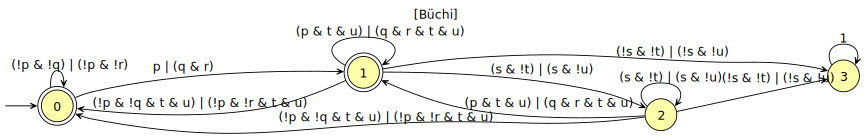

  I: I Total Edges Out: 1
	0:  1  
  0: 0 Total Edges Out: 2
	0:  ((!p & !q) | (!p & !r))  
	1:  (p | (q & r))  
  1: 1 Total Edges Out: 4
	0:  ((((!p & !q) & t) & u) | (((!p & !r) & t) & u))  
	1:  (((p & t) & u) | (((q & r) & t) & u))  
	2:  ((s & !t) | (s & !u))  
	3:  ((!s & !t) | (!s & !u))  
  2: 2 Total Edges Out: 4
	0:  ((((!p & !q) & t) & u) | (((!p & !r) & t) & u))  
	1:  (((p & t) & u) | (((q & r) & t) & u))  
	2:  ((s & !t) | (s & !u))  
	3:  ((!s & !t) | (!s & !u))  
  3: 3 Total Edges Out: 1
	3:  1  

Predicates:  ['p', 'q', 'r', 's', 't', 'u']
Terminals:   ['3']
Start State: 0


In [147]:
formula.printSelf()
formula.showGraph(graphPrint,graphFile)

#auto.printGraph()

print(auto)
print(f'Predicates:  {auto.predicates}')
print(f'Terminals:   {auto.terminals}')
print(f'Start State: {formula.getStartState()}')


# Trace Generation

In [148]:
allTraces = ''
auto.reset()

print(f'{dLineSeparator}\nRun of Length {runLen}\n')
for run in range(0,numRuns):
    auto.genTrace(traceQual=traceQual)
    
auto.printVisitLog()

with open(path.joinpath('data.txt'), 'w') as f:
    f.write(f'{startFormula}\n')
    for trace in (auto.allTraces):
        f.write(f'{trace.traceAsStr()}\n')
        print(trace.traceAsStr())
        

Run of Length 10

From State To State Visit Count
I:   0 ->   0                                   | Edges Out:   0/  1
0:   0 ->  19   1 ->  15                        | Edges Out:   2/  2
1:   0 ->   2   1 ->  11   2 ->  10   3 ->   3  | Edges Out:   4/  4
2:   0 ->   3   1 ->   2   2 ->   6   3 ->   3  | Edges Out:   4/  4
3:   3 ->  26                                   | Edges Out:   1/  1
p;q,r,t,u;s,!u;!p,!q,t,u;!p,!r;p;!s,!u;1;1;1;
!p,!q;!p,!r;p;!p,!q,t,u;q,r;q,r,t,u;s,!u;p,t,u;s,!u;s,!u;
!p,!r;q,r;q,r,t,u;p,t,u;q,r,t,u;p,t,u;p,t,u;s,!t;s,!u;s,!u;
!p,!q;p;q,r,t,u;s,!u;!s,!u;1;1;1;1;1;
p;!p,!r,t,u;!p,!q;!p,!q;!p,!r;q,r;s,!t;s,!u;!s,!t;1;
p;p,t,u;!s,!u;1;1;1;1;1;1;1;
q,r;s,!u;s,!t;q,r,t,u;p,t,u;s,!t;!p,!r,t,u;!p,!q;!p,!r;p;
!p,!r;!p,!r;!p,!r;!p,!q;!p,!q;!p,!r;!p,!r;!p,!r;p;q,r,t,u;
!p,!q;q,r;s,!t;s,!u;!p,!r,t,u;p;!s,!u;1;1;1;
q,r;s,!t;!s,!u;1;1;1;1;1;1;1;


### Show paths covered by traces  

Green edges are covered edges moving between accepting states or over accepting edges  
Red edges are covered edges moving to trap states  
Black edges are not covered by any trace  

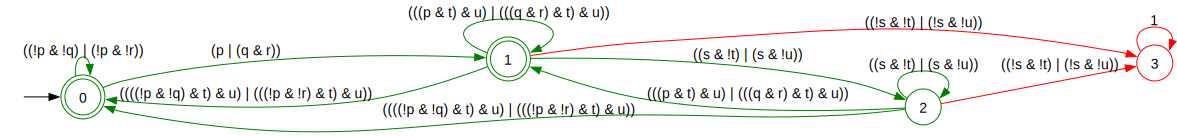

In [149]:
auto.printGraph(traceGraphPrint,traceSource,traceGraphFile)


### Different ways to display the traces:

`auto.printTraceLog ` has different print options depending on verbose setting (default is verbose=0):
* 0 - Print a simple list of states seen
* 1 - Print the trace through the automaton with state transitions and predicates holding
* 2 - Print a detailed trace evaluation

Setting `color=True` will generate a colorized version of verbose = 0 or 1 where: green indicates state was accepting, red indicates state is a non-accepting trap/sink

In [161]:
print(f'Trace #         States Seen:')
for i, trace in enumerate(auto.allTraces):
    print(f' {i:3}:    ',end='')
    auto.printTraceLog(trace,verbose=0,color=True)

for i, trace in enumerate(auto.allTraces):
    print(f'\nTrace: {i:3}')
    auto.printTraceLog(trace,verbose=1,color=True)

Trace #         States Seen:
   0:    1, 1, 1, 2, 0, 0, 1, 3, 3, 3, 3
   1:    0, 0, 0, 1, 0, 1, 1, 2, 1, 2, 2
   2:    0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2
   3:    0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 3
   4:    1, 1, 0, 0, 0, 0, 1, 2, 2, 3, 3
   5:    1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3
   6:    1, 1, 2, 2, 1, 1, 2, 0, 0, 0, 1
   7:    0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1
   8:    0, 0, 1, 2, 2, 0, 1, 3, 3, 3, 3
   9:    1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3

Trace:   0
S   -> S'   Predicates
----------------------------------------
0   -> 1  : ['p']
0   -> 1  : ['p']
1   -> 1  : ['q', 'r', 't', 'u']
1   -> 2  : ['s', '!u']
2   -> 0  : ['!p', '!q', 't', 'u']
0   -> 0  : ['!p', '!r']
0   -> 1  : ['p']
1   -> 3  : ['!s', '!u']
3   -> 3  : ['1']
3   -> 3  : ['1']
3   -> 3  : ['1']

Trace:   1
S   -> S'   Predicates
----------------------------------------
0   -> 0  : ['!p', '!q']
0   -> 0  : ['!p', '!q']
0   -> 0  : ['!p', '!r']
0   -> 1  : ['p']
1   -> 0  : ['!p', '!q', 't', 'u']
0   -> 1  : ['q', 'r']
1   -> 1

# Compare Automata

This code compares two automata by running traces from automaton A on automaton B and vis versa

In [151]:
compPrint = {'Print'  : True,
             'Source' : False,
             'Stats'  : False 
             }
compFile = {'save'   : False,
             'name'   : path.joinpath('graph'),
             'format' : 'png'}


In [152]:
# formula1 = Formula.setFormula(dOptions,'F(G(p -> X(q))) & G(r -> (F(!s)))')
# formula2 = Formula.setFormula(dOptions,'G(p -> (X(q) & G(r -> F(!s))))')
formula1 = Formula.setFormula(dOptions,'F(G(p -> X(q))) & G(r -> (F(s)))')
formula2 = Formula.setFormula(dOptions,'F(G((p -> X(q))) & G((r -> F(s))))')
formula1 = Formula.setFormula(dOptions,'G(p <-> g) & F(!p) & G(a -> p) & G(b->p) & G(c->p) & GFa & GFb & GFc & GF(p & !a & !b & !c) & G(a -> X c) & G((a->!b) & (b->!a)) & G(b U (!b | a))')
formula2 = Formula.setFormula(dOptions,'(G((l ↔ p) ∧ F(¬p)) ∧ G((a ∨ b ∨ c ∨ d -> p)) ∧ F(a ∧ c) ∧ F(b) ∧ ((a -> Xc) ∧ (¬(a ∧ b))) ∧ (b -> (¬a U ¬b)) ∧ F(¬(a ∨ b ∨ c ∨ d)))')
auto1 = buildAutomaton(formula1)
auto2 = buildAutomaton(formula2)


Generating LALR tables
Generating LALR tables


Starting formula:
F!p & G(((g & p) | (!g & !p)) & (!a | p) & (!b | p) & (!c | p) & (!a | !b) & Fa & Fb & Fc & F(!a & !b & !c & p) & (!a | Xc))


spot.formula("F!p & G(((g & p) | (!g & !p)) & (!a | p) & (!b | p) & (!c | p) & (!a | !b) & Fa & Fb & Fc & F(!a & !b & !c & p) & (!a | Xc))")

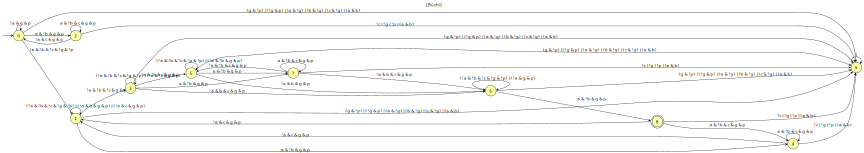

Starting formula:
Fb & (!a | Xc) & F(a & c) & (!a U !b) & G(((l & p) | (!l & !p)) & (p | (!a & !b & !c & !d)) & F!p)


spot.formula("Fb & (!a | Xc) & F(a & c) & (!a U !b) & G(((l & p) | (!l & !p)) & (p | (!a & !b & !c & !d)) & F!p)")

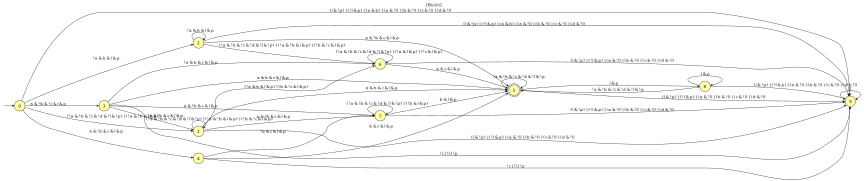

In [153]:
formula1.printSelf()
formula1.showGraph(compPrint,compFile)
formula2.printSelf()
formula2.showGraph(compPrint,compFile)


### Generate a batch of traces for each automaton


In [154]:
auto1.reset(resetLog=True)
auto2.reset(resetLog=True)
for run in range(0,numRuns):
    auto1.genTrace(tracePrint=False)
    auto2.genTrace(tracePrint=False)
    
print(f'Automaton 1 Traces:')
auto1.printVisitLog()
for trace in (auto1.allTraces):
    print(trace.traceAsStr())
    
print(f'Automaton 2 Traces:')
auto2.printVisitLog()
for trace in (auto2.allTraces):
    print(trace.traceAsStr())

Automaton 1 Traces:
From State To State Visit Count
I:   0 ->   0                                              | Edges Out:   0/  1
0:   0 ->   4   1 ->   8   2 ->   2   9 ->   1             | Edges Out:   4/  4
1:   1 ->   8   3 ->   6   4 ->   4   9 ->   1             | Edges Out:   4/  4
2:   0 ->   1   2 ->   1   9 ->   1                        | Edges Out:   3/  3
3:   3 ->   0   5 ->   3   6 ->   0   7 ->   3   9 ->   0  | Edges Out:   2/  5
4:   1 ->   3   4 ->   2   9 ->   1                        | Edges Out:   3/  3
5:   5 ->   2   6 ->   0   7 ->   2   9 ->   1             | Edges Out:   3/  4
6:   6 ->   1   8 ->   0   9 ->   1                        | Edges Out:   2/  3
7:   5 ->   1   6 ->   3   7 ->   6   9 ->   0             | Edges Out:   3/  4
8:   1 ->   0   4 ->   0   9 ->   0                        | Edges Out:   0/  3
9:   9 ->  34                                              | Edges Out:   1/  1
!a,!b,!c,!g,!p;a,!b,g,p;a,!b,c,g,p;!a,c,g,p;!a,c,g,p;!a,b,g,p;!a,c,g

In [155]:
for trace in auto1.allTraces:
    auto1.evaluate(trace)
    print(f'Evaluation Trace Log: ',end='')
    auto1.printTraceLog(trace,verbose=1)
    print('')

for trace in auto1.allTraces:
    auto2.evaluate(trace)
    print(f'Evaluation Trace Log: ',end='')
    auto1.printTraceLog(trace,verbose=1)
    print('')


State: 0 -> 1, Symbols: ['!a', '!b', '!c', '!g', '!p'] : True Coverage 5  ((((!a & !b) & !c) & !g) & !p) 
State: 1 -> 4, Symbols: ['a', '!b', 'g', 'p'] : True Coverage 4  (((a & !b) & g) & p) 
State: 4 -> 4, Symbols: ['a', '!b', 'c', 'g', 'p'] : True Coverage 5  ((((a & !b) & c) & g) & p) 
State: 4 -> 1, Symbols: ['!a', 'c', 'g', 'p'] : True Coverage 4  (((!a & c) & g) & p) 
State: 1 -> 1, Symbols: ['!a', 'c', 'g', 'p'] : True Coverage 4  ((((((!a & !b) & !c) & !g) & !p) | (((!a & b) & g) & p)) | (((!a & c) & g) & p)) 
State: 1 -> 1, Symbols: ['!a', 'b', 'g', 'p'] : True Coverage 4  ((((((!a & !b) & !c) & !g) & !p) | (((!a & b) & g) & p)) | (((!a & c) & g) & p)) 
State: 1 -> 1, Symbols: ['!a', 'c', 'g', 'p'] : True Coverage 4  ((((((!a & !b) & !c) & !g) & !p) | (((!a & b) & g) & p)) | (((!a & c) & g) & p)) 
State: 1 -> 9, Symbols: ['g', '!p'] : True Coverage 2  ((((((g & !p) | (!g & p)) | (a & !g)) | (b & !g)) | (c & !g)) | (a & b)) 
State: 9 -> 9, Symbols: ['1'] : True Coverage 1  1 


From State To State Visit Count
I:   0 ->   0                                              | Edges Out:   0/  1
0:   0 ->   4   1 ->   8   2 ->   2   9 ->   1             | Edges Out:   4/  4
1:   1 ->   8   3 ->   6   4 ->   4   9 ->   1             | Edges Out:   4/  4
2:   0 ->   1   2 ->   1   9 ->   1                        | Edges Out:   3/  3
3:   3 ->   0   5 ->   3   6 ->   0   7 ->   3   9 ->   0  | Edges Out:   2/  5
4:   1 ->   3   4 ->   2   9 ->   1                        | Edges Out:   3/  3
5:   5 ->   2   6 ->   0   7 ->   2   9 ->   1             | Edges Out:   3/  4
6:   6 ->   1   8 ->   0   9 ->   1                        | Edges Out:   2/  3
7:   5 ->   1   6 ->   3   7 ->   6   9 ->   0             | Edges Out:   3/  4
8:   1 ->   0   4 ->   0   9 ->   0                        | Edges Out:   0/  3
9:   9 ->  34                                              | Edges Out:   1/  1


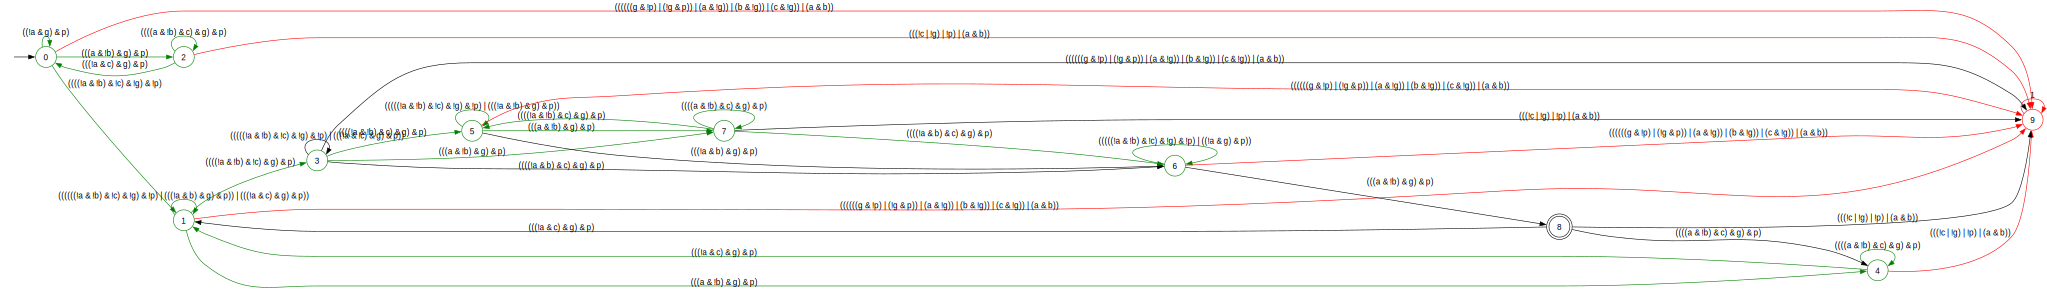

From State To State Visit Count
I:   0 ->   0                                              | Edges Out:   0/  1
0:   1 ->   1   2 ->   2   3 ->   3   4 ->   3   9 ->   1  | Edges Out:   5/  5
1:   1 ->   0   5 ->   1   6 ->   0   7 ->   0   9 ->   0  | Edges Out:   1/  5
2:   2 ->   1   5 ->   1   6 ->   1   9 ->   0             | Edges Out:   3/  4
3:   1 ->   0   5 ->   1   6 ->   0   7 ->   2   9 ->   0  | Edges Out:   2/  5
4:   5 ->   1   7 ->   1   9 ->   1                        | Edges Out:   3/  3
5:   5 ->   2   8 ->   3   9 ->   4                        | Edges Out:   3/  3
6:   5 ->   1   6 ->   0   9 ->   0                        | Edges Out:   1/  3
7:   5 ->   1   7 ->   1   9 ->   2                        | Edges Out:   3/  3
8:   5 ->   1   8 ->   3   9 ->   2                        | Edges Out:   3/  3
9:   9 ->  60                                              | Edges Out:   1/  1


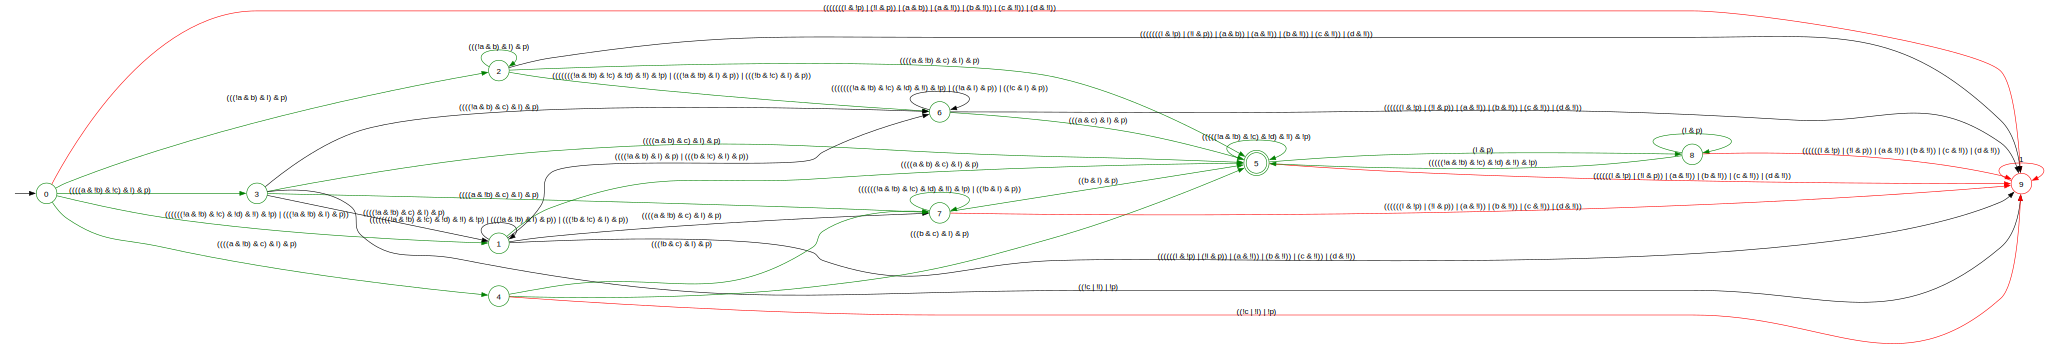

In [156]:
auto1.printVisitLog()
auto1.printGraph(traceGraphPrint,traceSource,traceGraphFile)

auto2.printVisitLog()
auto2.printGraph(traceGraphPrint,traceSource,traceGraphFile)


In [157]:
trace.start()
done = False
while done != True:
    step = trace.next()
    print(step)
    if step == None:
        done = True

0   -> 0  : ['!a', 'g', 'p']
0   -> 0  : ['!a', 'g', 'p']
0   -> 1  : ['!a', '!b', '!c', '!g', '!p']
1   -> 3  : ['!a', '!b', '!c', 'g', 'p']
3   -> 7  : ['a', '!b', 'g', 'p']
7   -> 7  : ['a', '!b', 'c', 'g', 'p']
7   -> 7  : ['a', '!b', 'c', 'g', 'p']
7   -> 7  : ['a', '!b', 'c', 'g', 'p']
7   -> 6  : ['!a', 'b', 'c', 'g', 'p']
6   -> 6  : ['!a', '!b', '!c', '!g', '!p']
None


In [158]:
done = False
while done != True:
    step = trace.back()
    print(step)
    if step == None:
        done = True

6   -> 6  : ['!a', '!b', '!c', '!g', '!p']
7   -> 6  : ['!a', 'b', 'c', 'g', 'p']
7   -> 7  : ['a', '!b', 'c', 'g', 'p']
7   -> 7  : ['a', '!b', 'c', 'g', 'p']
7   -> 7  : ['a', '!b', 'c', 'g', 'p']
3   -> 7  : ['a', '!b', 'g', 'p']
1   -> 3  : ['!a', '!b', '!c', 'g', 'p']
0   -> 1  : ['!a', '!b', '!c', '!g', '!p']
0   -> 0  : ['!a', 'g', 'p']
0   -> 0  : ['!a', 'g', 'p']
None


In [159]:
a = ['r', 'g', '!y']
b = ['y', 'r']
c = ['r', 'y']
d = [a[i].replace('!','') for i in range(len(a))]
print(f'{d}')
print(set(a).intersection(b))
print(set(b).intersection(a))
print(set(a).intersection(c) == set(a))
print(set(d).intersection(c) == set(d))
print(set(b).intersection(c) == set(b))

['r', 'g', 'y']
{'r'}
{'r'}
False
False
True
